<hr />
<em>LTAT.06.011 – Fundamentals of Autonomous Driving</em>

## Motion prediction (Naive methods)


 In this Lab, we will explore some very naive approaches to predict motion of a target object. Tasks are orientated in a way that the difficulty of accessing the prediction problem increases as we progress forward. The crux here is to understand how naive prediction models perform well on simple scenarios but their performance deterioates as scene complexity increases.


#### Deliverable for the lab exercise:

You will submit the same `jupyter-notebook` file. Please note that you don't need to submit the `helper.py` <b>unless</b> you do any modifications there. You are required to fill the missing code snippets. Additionally, some sections require your detailed answers in the form of text.
Submit the deliverable(s) through Moodle. Late policy is the same as earlier. For a delay of each day beyond the submission deadline, there is a `10%` penalty on the total marks. In other words, if you are late by one day, the score is capped at `90%` of the total marks. And if you are late by `10` days, no marks can be awarded for the lab exercise.

<hr />



### Getting started

<em> Imports </em>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper import generate_linear_trajectory, generate_curved_trajectory, generate_circle_trajectory, generate_sin_wave_trajectory

We learned from the lecture that the motion of an object is usually modelled in the form trajectory. In following tasks you will be given a ground-turth trajectory. You are required to write a simple motion predicion method that takes in half ground-truth trajectoy and estimates `n` future steps using history of the ground-truth. Please read the code comments carefully while writing your solution.

<hr />


### Task-1: Linear trajectory: 
In this task we will model a linear trajectory using constant velocity model.

<hr />

<em> Run code section below, it should display an example linear trajectory </em>

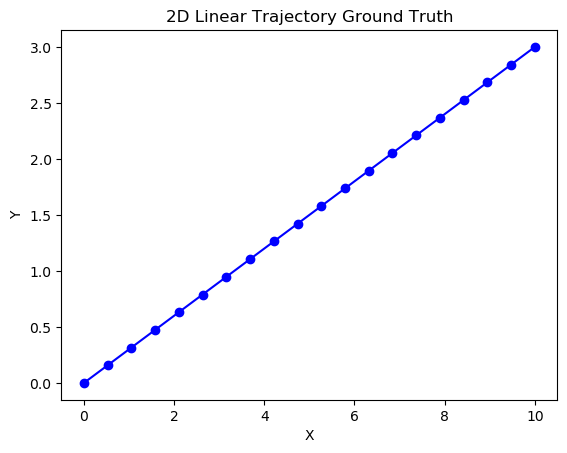

In [2]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D linear trajectory.
linear_trajectory_ground_truth = generate_linear_trajectory(start_point, end_point, num_points)


# Plot the trajectory
x_vals = [p[0] for p in linear_trajectory_ground_truth]
y_vals = [p[1] for p in linear_trajectory_ground_truth]
plt.plot(x_vals, y_vals, 'bo-')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Linear Trajectory Ground Truth')
plt.show()

<em> Write a function `predict_trajectory` that takes in 2D trajectory and predicts next `n` number of future trajectory points using simple constant velocity model. You can assume fixed time delta `dt=0.1`</em>

In [19]:
###############################
###### CODE STARTS HERE #######
###############################

def predict_trajectory(trajectory, n, acceleration=True):
    dt=0.1

    # Calculate the velocity vector from the trajectory
    velocity = np.diff(trajectory, axis=0) / dt
    
    if acceleration:
        # Calculate the acceleration vector from the velocity vector
        acceleration = np.diff(velocity, axis=0) / dt
        
        # Assume the acceleration remains constant and extrapolate the next n points
        for i in range(n):
            last_point = trajectory[-1]
            last_velocity = velocity[-1]
            last_acceleration = acceleration[-1]
            next_point = last_point + last_velocity*dt + 0.5*last_acceleration*dt**2
            trajectory = np.vstack((trajectory, next_point))
            velocity = np.vstack((velocity, last_velocity + last_acceleration*dt))
            acceleration = np.vstack((acceleration, last_acceleration))
    
    else:
        # Assume constant velocity and extrapolate the next n points
        for i in range(n):
            last_point = trajectory[-1]
            last_velocity = velocity[-1]
            next_point = last_point + last_velocity*dt
            trajectory = np.vstack((trajectory, next_point))
            velocity = np.vstack((velocity, last_velocity))
    
    return trajectory


###############################
###### CODE ENDS HERE #########
###############################

<em> Call the `predict_trajectory` method you wrote above with required arguments</em>

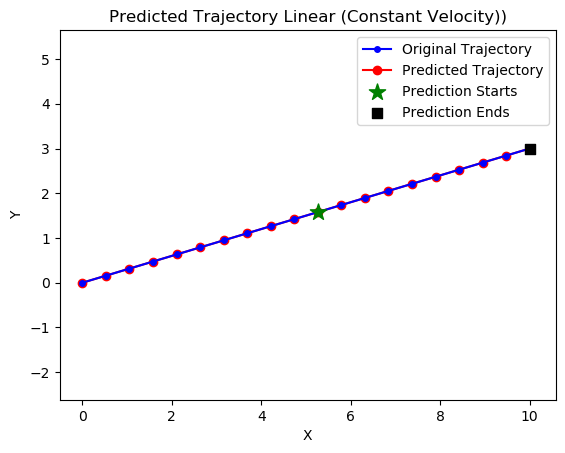

In [24]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D linear trajectory.
linear_trajectory_ground_truth = generate_linear_trajectory(start_point, end_point, num_points)


# Define the time step and number of points to predict
n = 10
half_len = int(len(linear_trajectory_ground_truth)/2)

###############################
###### CODE STARTS HERE #######
###############################

# Comment this line and call predict_trajectory method which your wrote above with required arguments
predicted_trajectory = linear_trajectory_ground_truth[:half_len]
# predicted_trajectory = predict_trajectory(linear_trajectory_ground_truth[:half_len], n, acceleration=False)


#############################
###### CODE ENDS HERE #######
#############################


# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(linear_trajectory_ground_truth[:, 0], linear_trajectory_ground_truth[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(linear_trajectory_ground_truth[half_len][0], linear_trajectory_ground_truth[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(linear_trajectory_ground_truth[-1][0], linear_trajectory_ground_truth[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Linear (Constant Velocity))')
ax.legend()
plt.show()

<span style="color:Red">Question: </span> Describe what you see. Also explain with your own understanding for which types of object types will this model work? When should it fail?
<br>

<span style="color:Green">Answer: </span>

<hr />


### Task-2: Curved trajectory: 
Similar to previous task, in this task we will try to model motion of an object which is moving in a curved path.

<hr />

<em> Run code section below, it should display an example curved trajectory </em>

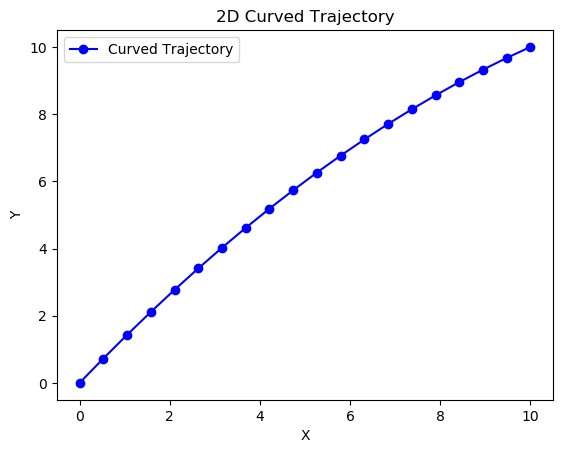

In [58]:
# Define the starting and ending points and number of points
start_point = (0, 0)
end_point = (10, 10)
num_points = 20

# Generate the curved trajectory
trajectory = generate_curved_trajectory(start_point, end_point, num_points)

# Plot the trajectory
fig, ax = plt.subplots()
ax.plot(trajectory[:, 0], trajectory[:, 1], 'bo-', label='Curved Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Curved Trajectory')
ax.legend()
plt.show()


<em> Call the `predict_trajectory` method you wrote above with required arguments</em>

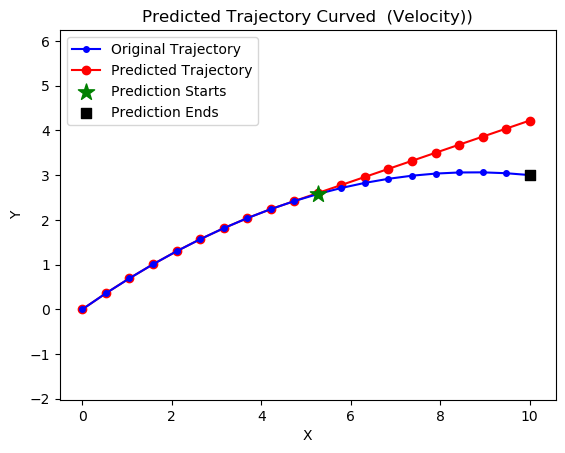

In [37]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D curved trajectory.
curved_trajectory_ground_truth = generate_curved_trajectory(start_point, end_point, num_points)


# Define the time step and number of points to predict
n = 10
half_len = int(len(curved_trajectory_ground_truth)/2)

###############################
###### CODE STARTS HERE #######
###############################

# Comment this line and call predict_trajectory method which your wrote above with required arguments
predicted_trajectory = curved_trajectory_ground_truth[:half_len]
predicted_trajectory = predict_trajectory(curved_trajectory_ground_truth[:half_len], n, acceleration=False)


#############################
###### CODE ENDS HERE #######
#############################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(curved_trajectory_ground_truth[:, 0], curved_trajectory_ground_truth[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(curved_trajectory_ground_truth[half_len][0], curved_trajectory_ground_truth[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(curved_trajectory_ground_truth[-1][0], curved_trajectory_ground_truth[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Curved  (Velocity))')
ax.legend()
plt.show()


<span style="color:Red">Question: </span> Describe what you see. Why the motion model failed here? Did you thought of this failure while you were answering the linear case? 
<br>

<span style="color:Green">Answer: </span>

<em> Lets modify the `predict_trajectory` method so that in addition to velocity we also make use of acceleration. What you need to do is to add a keyword parameter `use_acceleration` to the function which by default should be `false`. Depending on the function call you can toggle the use acceleration in the prediction functionality.</em>

In [35]:
###############################
###### CODE STARTS HERE #######
###############################

# Write the updated predit_trajectory function here OR update it where you wrote it above

#############################
###### CODE ENDS HERE #######
#############################


<em> Call the updated `predict_trajectory` method with `use_acceleration=True` </em>

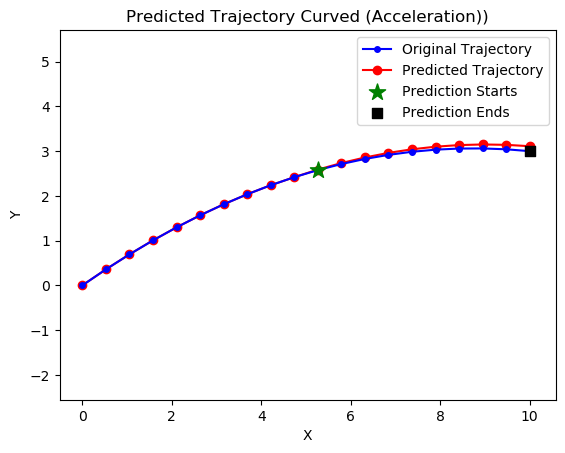

In [38]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D curved trajectory.
curved_trajectory_ground_truth = generate_curved_trajectory(start_point, end_point, num_points)


# Define the time step and number of points to predict
n = 10
half_len = int(len(curved_trajectory_ground_truth)/2)

###############################
###### CODE STARTS HERE #######
###############################

# Comment this line and call predict_trajectory method which your wrote above with required arguments
predicted_trajectory = curved_trajectory_ground_truth[:half_len]
predicted_trajectory = predict_trajectory(curved_trajectory_ground_truth[:half_len], n, acceleration=True)


#############################
###### CODE ENDS HERE #######
#############################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(curved_trajectory_ground_truth[:, 0], curved_trajectory_ground_truth[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(curved_trajectory_ground_truth[half_len][0], curved_trajectory_ground_truth[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(curved_trajectory_ground_truth[-1][0], curved_trajectory_ground_truth[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Curved (Acceleration))')
ax.legend()
plt.show()

<span style="color:Red">Question: </span> Describe what you see. From your understanding, If we continue adding more derivatives, would we gain more better results?
<br>

<span style="color:Green">Answer: </span>

<hr />


### Task-3: Circular trajectory: 
Lets test our updated `predict_trajectory` for an object which is moving in circle.

<hr />

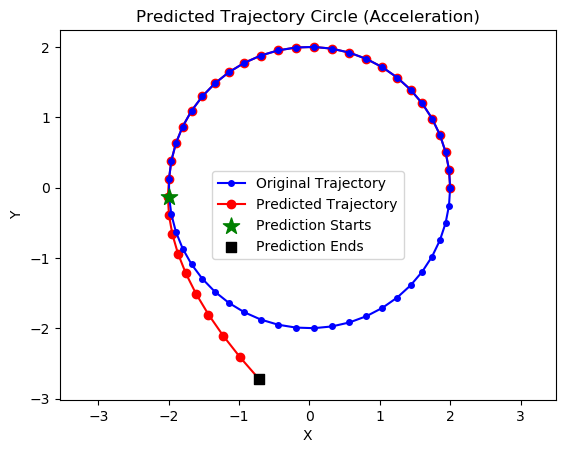

In [57]:
# Define the center of the circle, radius, and number of points
center = (0, 0)
radius = 2
num_points = 50

# Generate the circular trajectory
circular_trajectory = generate_circle_trajectory(center, radius, num_points)

# Define the time step and number of points to predict
n = 10
half_len = int(len(circular_trajectory)/2)


###############################
###### CODE STARTS HERE #######
###############################


# Comment this line and call the updated predict_trajectory method with acceleration=True for circular trajectory
predicted_trajectory = circular_trajectory[:half_len]

# # Predict the next n points of the trajectory without acceleration
predicted_trajectory = predict_trajectory(circular_trajectory[:half_len], n, acceleration=True)

#############################
###### CODE ENDS HERE #######
#############################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(circular_trajectory[:, 0], circular_trajectory[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(circular_trajectory[half_len][0], circular_trajectory[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(predicted_trajectory[-1][0], predicted_trajectory[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Circle (Acceleration)')
ax.legend()
plt.show()



<span style="color:Red">Question: </span> Describe what you see. 
<br>

<span style="color:Green">Answer: </span>

<span style="color:Yellow">Question: (Optional): </span> How would a model know that the object is moving in circular path, any suggestions?

<span style="color:Green">Answer: </span>

<hr />


### Task-4: Noisy measurements
Previously, we were relying on smooth trajectories as ground-truth but real world data is noisy. The past trajectory given to the prediction model can have both longitudinal and lateral noise. In this task, you are required to re-run `one` experiment (choose any) which you performed previously but this time you should add noise both along x and y axis of the ground-truth trajectory. You can copy code snippets from previous sections.

<hr />

<em> Get a ground truth trajectory, add some measurement noise along both x & y axis, call the predicti method and visualize the results</em>

In [ ]:
###############################
###### CODE STARTS HERE #######
###############################




#############################
###### CODE ENDS HERE #######
#############################

<span style="color:Red">Question: </span> Describe your experiment results. Did the model handle noisy data well?
<br>

<span style="color:Green">Answer: </span>

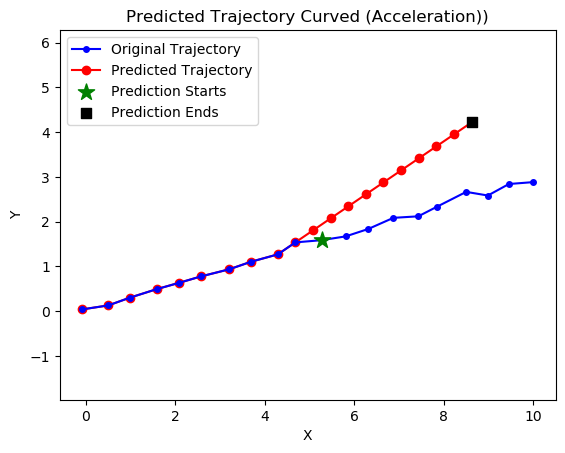

In [70]:
# Generate the trajectory
start_point = (0, 0)        # Start of the trajectory
end_point = (10, 3)         # End of the trajectory
num_points = 20             # Number of points in the trajectory

# Following method takes in tuple of starting point, ending point and number of points in between. It returns a 2D curved trajectory.
curved_trajectory_ground_truth = generate_linear_trajectory(start_point, end_point, num_points)


measurement_noise = 0.06
curved_trajectory_ground_truth = curved_trajectory_ground_truth + np.random.randn(len(curved_trajectory_ground_truth), 2) * measurement_noise

# Define the time step and number of points to predict
n = 10
half_len = int(len(curved_trajectory_ground_truth)/2)

###############################
###### CODE STARTS HERE #######
###############################

# Comment this line and call predict_trajectory method which your wrote above with required arguments
predicted_trajectory = curved_trajectory_ground_truth[:half_len]
predicted_trajectory = predict_trajectory(curved_trajectory_ground_truth[:half_len], n, acceleration=False)


#############################
###### CODE ENDS HERE #######
#############################

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(curved_trajectory_ground_truth[:, 0], curved_trajectory_ground_truth[:, 1], 'bo-', label='Original Trajectory', markersize=4, zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(curved_trajectory_ground_truth[half_len][0], curved_trajectory_ground_truth[half_len][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.scatter(predicted_trajectory[-1][0], predicted_trajectory[-1][1], label='Prediction Ends', marker='s'  , color='black', s=[50],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory Curved (Acceleration))')
ax.legend()
plt.show()

In [59]:
# Generate the circular trajectory
trajectory = generate_sin_wave_trajectory(length=15, amplitude=1, period=1, wavelength=10, num_points=30)

# Define the time step and number of points to predict
dt = 0.5
n = 12

measurement_noise = 0.06
t = np.arange(0, 15, dt)
trajectory_measurement = trajectory + np.random.randn(len(trajectory), 2) * measurement_noise
# x_meas = trajectory[:, 0] + np.random.randn(len(trajectory)) * measurement_noise
# y_meas = trajectory[:, 1] + np.random.randn(len(trajectory)) * measurement_noise

# Predict the next n points of the trajectory without acceleration
predicted_trajectory, predicted_points = predict_trajectory(trajectory_measurement[:int(len(trajectory_measurement)/2)], dt, n, acceleration=True)

# Plot the original and predicted trajectories
fig, ax = plt.subplots()
ax.plot(trajectory_measurement[:, 0], trajectory_measurement[:, 1], 'bo-', label='Original Trajectory',  zorder=2)
ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'bo-', label='Predicted Trajectory', color='red',  zorder=1)
ax.scatter(predicted_points[0][0], predicted_points[0][1], label='Prediction Starts', marker='*'  , color='green', s=[150],  zorder=3)
ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Trajectory (No Acceleration)')
ax.legend()
plt.show()


TypeError: predict_trajectory() got multiple values for argument 'acceleration'

In [4]:
class KalmanFilter:
    def __init__(self, observation, acceleration=False, measurement_noise=0.1, process_noise=0.001, dt=0.1):
        
        self.dims = 2

        ################################
        ### Kalman Filter Attributes ###
        ################################


        if acceleration:
            self.x = np.array([observation, [0., 0.], [0., 0.]]).flatten()
            self.P = np.vstack((
                                np.hstack((10*np.eye(self.dims), np.zeros((self.dims, 2*self.dims)))),
                                np.hstack((np.zeros((self.dims, self.dims)), 2*np.eye(self.dims), np.zeros((self.dims, self.dims)) )),
                                np.hstack((np.zeros((self.dims, 2*self.dims)), 1*np.eye(self.dims) )),
                                ))
            self.H = np.hstack((np.eye(self.dims), np.zeros((self.dims, 2*self.dims))))
            self.R = measurement_noise * np.eye(self.dims)
            self.F = np.vstack((
                                np.hstack((np.eye(self.dims), dt*np.eye(self.dims), (dt**2)/2*np.eye(self.dims))),
                                np.hstack((np.zeros((self.dims, self.dims)), np.eye(self.dims), dt*np.eye(self.dims))),
                                np.hstack((np.zeros((self.dims, 2 * self.dims)), np.eye(self.dims)))
                                ))
            self.Q = process_noise * np.eye(3*self.dims)

        else:
            self.x = np.array([observation, [0., 0.]]).flatten()
            self.P = np.vstack((
                                np.hstack((10*np.eye(self.dims), np.zeros((self.dims, self.dims)))),
                                np.hstack((np.zeros((self.dims, self.dims)), 2*np.eye(self.dims) )),
                                ))
            self.H = np.hstack((np.eye(self.dims), np.zeros((self.dims, self.dims))))
            self.F = np.vstack((
                                np.hstack((np.eye(self.dims), dt*np.eye(self.dims))),
                                np.hstack((np.zeros((self.dims, self.dims)), np.eye(self.dims))),
                                ))
            self.Q = process_noise * np.eye(2*self.dims)
            self.R = measurement_noise * np.eye(self.dims)



    def update(self, observation):

        ############################
        ### Kalman Filter Update ###
        ############################

        # calculate error or in KF terms 'y' --> difference between state and measurement
        z = observation
        err = z - np.matmul(self.H, self.x)
        # Get system uncertainty in measurement space
        S = np.matmul(np.matmul(self.H, self.P), self.H.transpose()) + self.R
        S_inv = np.linalg.inv(S)
        
        # Update Kalman gain
        K = np.matmul(np.matmul(self.P, self.H.transpose()), S_inv)
        # Update state with system cov
        self.x = self.x + np.matmul(K, err)
        self.P = np.matmul(np.eye(self.x.shape[0]) - np.matmul(K, self.H), self.P)

    def predict(self):

        #############################
        ### Kalman Filter Predict ###
        #############################

        self.x = np.matmul(self.F, self.x)
        self.P = np.matmul(np.matmul(self.F, self.P), self.F.transpose()) + self.Q

    def get_state(self):

        #########################
        ### Get Current State ###
        #########################
        return self.x

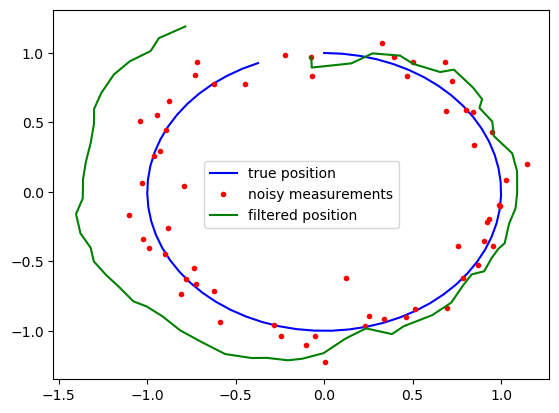

In [5]:
# create Kalman filter instance
dt = 0.1
measurement_noise = 0.1
process_noise = 0.001

# simulate noisy measurements of a moving object
t = np.arange(0, 6, dt)

x_true = np.sin(t)
y_true = np.cos(t)

x_meas = x_true + np.random.randn(len(t)) * measurement_noise
y_meas = y_true + np.random.randn(len(t)) * measurement_noise

kf = KalmanFilter([x_true[0], y_true[0]], acceleration=True, process_noise=process_noise, measurement_noise=measurement_noise, dt=dt)


# run Kalman filter on measurements
x_filtered = np.zeros_like(x_meas)
y_filtered = np.zeros_like(y_meas)
for i in range(len(t)):
    kf.predict()
    kf.update(np.array([x_meas[i], y_meas[i]]))
    x_filtered[i], y_filtered[i] = kf.get_state()[0], kf.get_state()[1]

# plot results
plt.plot(x_true, y_true, 'b-', label='true position')
plt.plot(x_meas, y_meas, 'r.', label='noisy measurements')
plt.plot(x_filtered, y_filtered, 'g-', label='filtered position')
plt.legend()
plt.show()

